# 一、前期工作

本文将采用`ResNet-50`实现鸟类图片的识别分类

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1LfiEQ43HhSsm7qU3KOM0Bg （提取码：0mhm）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

import pathlib

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/bird_photos"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 565


# 二、数据预处理

|文件夹|数量|
|:--:|:--:|
|Bananaquit|	166 张
|Black Throated Bushtiti|	111 张
|Black skimmer|		122 张
|Cockatoo|	166张

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 8
img_height = 224
img_width = 224

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 565 files belonging to 4 classes.
Using 452 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 565 files belonging to 4 classes.
Using 113 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['Bananaquit', 'Black Skimmer', 'Black Throated Bushtiti', 'Cockatoo']


## 2. 可视化数据

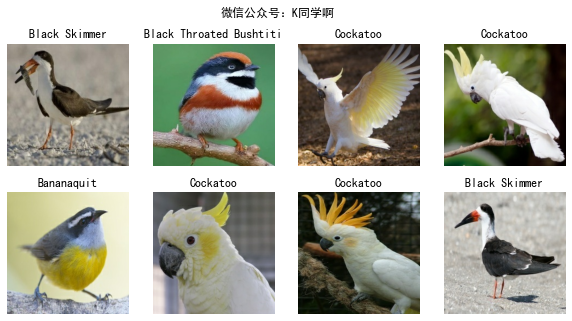

In [9]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号：K同学啊")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

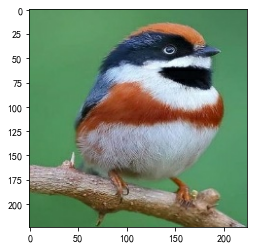

In [10]:
plt.imshow(images[1].numpy().astype("uint8"))

## 3. 再次检查数据 

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


- `Image_batch`是形状的张量（8, 224, 224, 3)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

## 4. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、残差网络（ResNet）介绍

## 1. 残差网络解决了什么

残差网络是为了解决神经网络隐藏层过多时，而引起的网络退化问题。退化（degradation）问题是指：当网络隐藏层变多时，网络的准确度达到饱和然后急剧退化，而且这个退化不是由于过拟合引起的。

**拓展：** 深度神经网络的“两朵乌云”

- 梯度弥散/爆炸

简单来讲就是网络太深了，会导致模型训练难以收敛。这个问题可以被标准初始化和中间层正规化的方法有效控制。（现阶段知道这么一回事就好了）

- 网络退化

随着网络深度增加，网络的表现先是逐渐增加至饱和，然后迅速下降，这个退化不是由于过拟合引起的。

## 2. ResNet-50介绍

ResNet-50有两个基本的块，分别名为`Conv Block`和`Identity Block`

**Conv Block结构：**

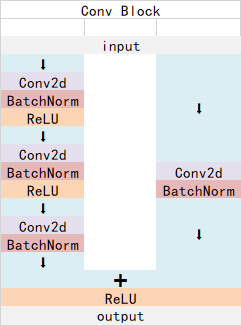

**Identity Block结构：**

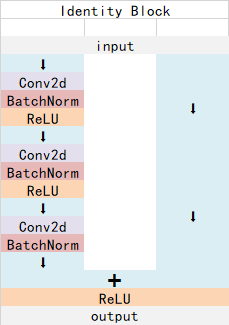

**ResNet-50总体结构：**

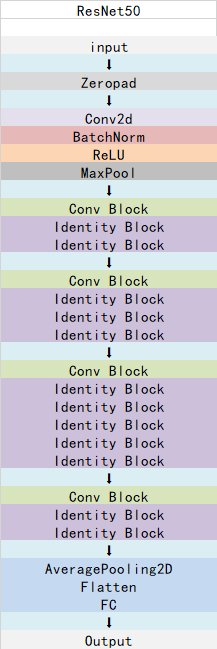

# 四、构建ResNet-50网络模型

下面是本文的重点，可以试着按照上面三张图自己构建一下ResNet-50

In [13]:
from keras import layers

from keras.layers import Input,Activation,BatchNormalization,Flatten
from keras.layers import Dense,Conv2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from keras.models import Model

def identity_block(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters

    name_base = str(stage) + block + '_identity_block_'

    x = Conv2D(filters1, (1, 1), name=name_base + 'conv1')(input_tensor)
    x = BatchNormalization(name=name_base + 'bn1')(x)
    x = Activation('relu', name=name_base + 'relu1')(x)

    x = Conv2D(filters2, kernel_size,padding='same', name=name_base + 'conv2')(x)
    x = BatchNormalization(name=name_base + 'bn2')(x)
    x = Activation('relu', name=name_base + 'relu2')(x)

    x = Conv2D(filters3, (1, 1), name=name_base + 'conv3')(x)
    x = BatchNormalization(name=name_base + 'bn3')(x)

    x = layers.add([x, input_tensor] ,name=name_base + 'add')
    x = Activation('relu', name=name_base + 'relu4')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters

    res_name_base = str(stage) + block + '_conv_block_res_'
    name_base = str(stage) + block + '_conv_block_'

    x = Conv2D(filters1, (1, 1), strides=strides, name=name_base + 'conv1')(input_tensor)
    x = BatchNormalization(name=name_base + 'bn1')(x)
    x = Activation('relu', name=name_base + 'relu1')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=name_base + 'conv2')(x)
    x = BatchNormalization(name=name_base + 'bn2')(x)
    x = Activation('relu', name=name_base + 'relu2')(x)

    x = Conv2D(filters3, (1, 1), name=name_base + 'conv3')(x)
    x = BatchNormalization(name=name_base + 'bn3')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=res_name_base + 'conv')(input_tensor)
    shortcut = BatchNormalization(name=res_name_base + 'bn')(shortcut)

    x = layers.add([x, shortcut], name=name_base+'add')
    x = Activation('relu', name=name_base+'relu4')(x)
    return x

def ResNet50(input_shape=[224,224,3],classes=1000):

    img_input = Input(shape=input_shape)
    x = ZeroPadding2D((3, 3))(img_input)

    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x =     conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x =     conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x =     conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x =     conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)

    model = Model(img_input, x, name='resnet50')
    
    # 加载预训练模型
    model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels.h5")

    return model

model = ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# 五、构建notop模型  

In [14]:
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Input,Activation,BatchNormalization,Flatten
# from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# def identity_block(input_tensor, kernel_size, filters, stage, block):

#     filters1, filters2, filters3 = filters

#     name_base = str(stage) + block + '_identity_block_'

#     x = Conv2D(filters1, (1, 1), name=name_base + 'conv1')(input_tensor)
#     x = BatchNormalization(name=name_base + 'bn1')(x)
#     x = Activation('relu', name=name_base + 'relu1')(x)

#     x = Conv2D(filters2, kernel_size,padding='same', name=name_base + 'conv2')(x)
#     x = BatchNormalization(name=name_base + 'bn2')(x)
#     x = Activation('relu', name=name_base + 'relu2')(x)

#     x = Conv2D(filters3, (1, 1), name=name_base + 'conv3')(x)
#     x = BatchNormalization(name=name_base + 'bn3')(x)

#     x = layers.add([x, input_tensor] ,name=name_base + 'add')
#     x = Activation('relu', name=name_base + 'relu4')(x)
#     return x


# def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

#     filters1, filters2, filters3 = filters

#     res_name_base = str(stage) + block + '_conv_block_res_'
#     name_base = str(stage) + block + '_conv_block_'

#     x = Conv2D(filters1, (1, 1), strides=strides, name=name_base + 'conv1')(input_tensor)
#     x = BatchNormalization(name=name_base + 'bn1')(x)
#     x = Activation('relu', name=name_base + 'relu1')(x)

#     x = Conv2D(filters2, kernel_size, padding='same', name=name_base + 'conv2')(x)
#     x = BatchNormalization(name=name_base + 'bn2')(x)
#     x = Activation('relu', name=name_base + 'relu2')(x)

#     x = Conv2D(filters3, (1, 1), name=name_base + 'conv3')(x)
#     x = BatchNormalization(name=name_base + 'bn3')(x)

#     shortcut = Conv2D(filters3, (1, 1), strides=strides, name=res_name_base + 'conv')(input_tensor)
#     shortcut = BatchNormalization(name=res_name_base + 'bn')(shortcut)

#     x = layers.add([x, shortcut], name=name_base+'add')
#     x = Activation('relu', name=name_base+'relu4')(x)
#     return x

# def ResNet50(input_shape=[224,224,3],classes=1000):

#     img_input = Input(shape=input_shape)
#     x = ZeroPadding2D((3, 3))(img_input)

#     x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
#     x = BatchNormalization(name='bn_conv1')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#     x =     conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
#     x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
#     x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

#     x =     conv_block(x, 3, [128, 128, 512], stage=3, block='a')
#     x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
#     x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
#     x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

#     x =     conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

#     x =     conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = AveragePooling2D((7, 7), name='avg_pool')(x)

#     x = Flatten()(x)

#     model = Model(img_input, x, name='resnet50')
    
#     # 加载预训练模型
#     model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
    
    
#     top_model = models.Sequential()
#     top_model.add(model)
#     top_model.add(Dense(classes, activation='relu'))
#     top_model.add(Dropout(0.2))
#     top_model.add(Dense(4, activation='softmax', name='fc1000'))

#     return top_model

# model = ResNet50()

# model.summary()

# 五、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [15]:
# 设置优化器，我这里改变了学习率。
opt = tf.keras.optimizers.Adam(learning_rate=1e-7)

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 六、训练模型

In [16]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
57/57 [==============================] - 12s 87ms/step - loss: 2.4394 - accuracy: 0.6620 - val_loss: 484.4415 - val_accuracy: 0.1858
Epoch 2/10
57/57 [==============================] - 3s 55ms/step - loss: 0.3268 - accuracy: 0.8904 - val_loss: 5.5874 - val_accuracy: 0.4513
Epoch 3/10
57/57 [==============================] - 3s 52ms/step - loss: 0.1593 - accuracy: 0.9558 - val_loss: 2.0023 - val_accuracy: 0.6726
Epoch 4/10
57/57 [==============================] - 3s 52ms/step - loss: 0.0546 - accuracy: 0.9869 - val_loss: 1.4410 - val_accuracy: 0.7788
Epoch 5/10
57/57 [==============================] - 3s 51ms/step - loss: 0.1656 - accuracy: 0.9567 - val_loss: 2.1653 - val_accuracy: 0.5487
Epoch 6/10
57/57 [==============================] - 3s 51ms/step - loss: 0.2403 - accuracy: 0.9221 - val_loss: 1.0641 - val_accuracy: 0.7257
Epoch 7/10
57/57 [==============================] - 3s 52ms/step - loss: 0.1774 - accuracy: 0.9377 - val_loss: 0.4922 - val_accuracy: 0.8673
Epoch 8/10

# 七、模型评估

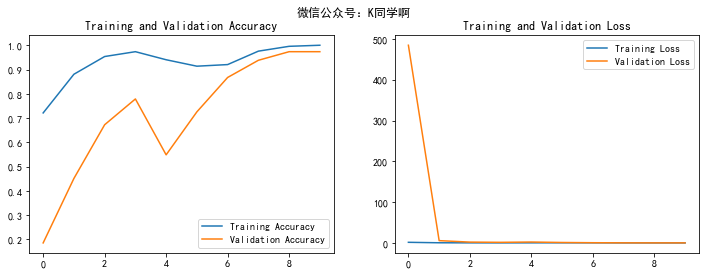

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号：K同学啊")

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 八、保存and加载模型

这是最简单的模型保存与加载方法哈

In [18]:
# 保存模型
model.save('model/my_model.h5')

In [19]:
# 加载模型
new_model = keras.models.load_model('model/my_model.h5')

# 九、预测

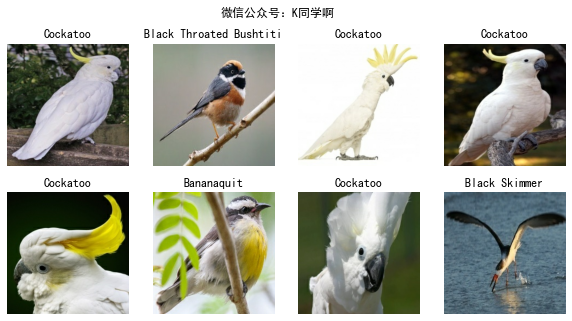

In [20]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号：K同学啊")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")

**其他精彩内容：**

- [**深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天**](https://mtyjkh.blog.csdn.net/article/details/116920825)
- [**深度学习100例-卷积神经网络（CNN）彩色图片分类 | 第2天**](https://mtyjkh.blog.csdn.net/article/details/116978213)
- [**深度学习100例-卷积神经网络（CNN）服装图像分类 | 第3天**](https://mtyjkh.blog.csdn.net/article/details/116992196)
- [**深度学习100例-卷积神经网络（CNN）花朵识别 | 第4天**](https://mtyjkh.blog.csdn.net/article/details/117079919)
- [**深度学习100例-卷积神经网络（CNN）天气识别 | 第5天**](https://mtyjkh.blog.csdn.net/article/details/117186183)
- [**深度学习100例-卷积神经网络（VGG-16）识别海贼王草帽一伙 | 第6天**](https://blog.csdn.net/qq_38251616/article/details/117331631)

**《深度学习100例》专栏直达：**[**【传送门】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

**需要数据的同学可以在评论中留下邮箱**，若时间久远可在文章左侧（电脑端可看）或者留言处寻找我的联系方式，如果觉得本文对你有帮助记得 **点个关注，给个赞，加个收藏**